<a href="https://colab.research.google.com/github/qin-na/SZPT-Q/blob/main/autoXRD%E7%BB%83%E4%B9%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

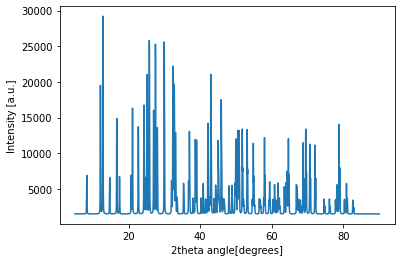

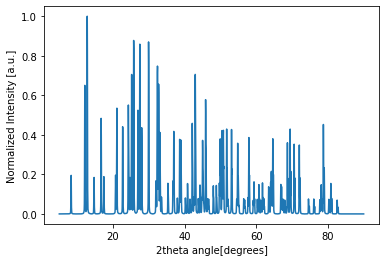

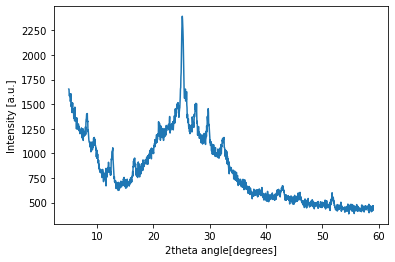

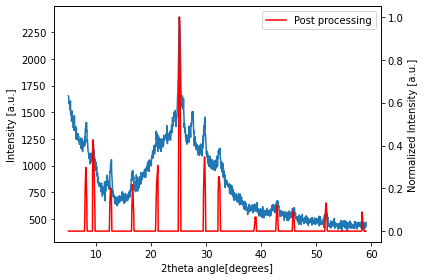

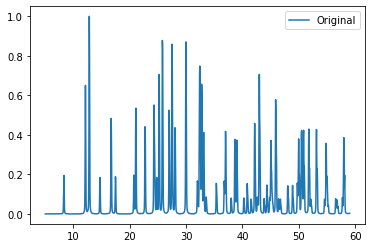

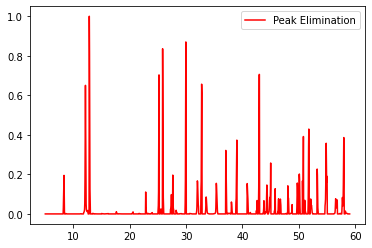

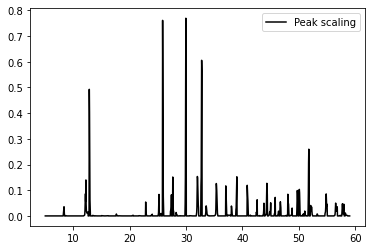

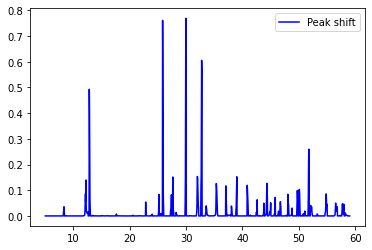

******************* ['RF'] ********************
accuracy_exp: 85.71%
accuracy_exp: 85.71%
accuracy_exp: 85.71%
accuracy_exp: 78.57%
accuracy_exp: 100.00%
CV  took 19.786451s!
Cross-validation results:
Folds: 5, mean acc: 0.871


In [4]:
#  使用机器学习的小数据集XRD分类

import time  
from sklearn.metrics import accuracy_score
import numpy as np  
import matplotlib.pyplot as plt
import os

import pandas as pd
from scipy.signal import savgol_filter
from scipy.signal import find_peaks_cwt
from sklearn.model_selection import train_test_split
import warnings
from keras.models import Model
from keras.models import Sequential
from sklearn.preprocessing import OneHotEncoder
import keras as K
warnings.filterwarnings('ignore')
# Multinomial Naive Bayes Classifier多项式朴素贝叶斯分类器
def naive_bayes_classifier(train_x, train_y):
    from sklearn.naive_bayes import MultinomialNB
    model = MultinomialNB(alpha=0.01)
    model.fit(train_x, train_y)
    return model


# KNN Classifier  KNN分类器
def knn_classifier(train_x, train_y):
    from sklearn.neighbors import KNeighborsClassifier
    model = KNeighborsClassifier(n_neighbors=3)
    model.fit(train_x, train_y)
    return model



# Random Forest Classifier  随机森林分类器
def random_forest_classifier(train_x, train_y):
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(n_estimators=100)
    model.fit(train_x, train_y)
    return model


# Decision Tree Classifier  决策树分类器
def decision_tree_classifier(train_x, train_y):
    from sklearn import tree
    model = tree.DecisionTreeClassifier()
    model.fit(train_x, train_y)
    return model


# GBDT(Gradient Boosting Decision Tree) Classifier  梯度提升决策树分类器
def gradient_boosting_classifier(train_x, train_y):
    from sklearn.ensemble import GradientBoostingClassifier
    model = GradientBoostingClassifier(n_estimators=100)
    model.fit(train_x, train_y)
    return model


# SVM Classifier  支持向量机分类器
def svm_classifier(train_x, train_y):
    from sklearn.svm import SVC
    model = SVC(kernel='rbf', probability=True)
    model.fit(train_x, train_y)
    return model



 # 3 layer neural network classficiation  三层神经网络分类
def mlp_classifier(train_x,train_y):
    from sklearn.neural_network import MLPClassifier
    model =  MLPClassifier(hidden_layer_sizes=(256,128,32), max_iter=20, alpha=1e-4,
                    solver='ada,', verbose=10, tol=1e-6, random_state=1,
                    learning_rate_init=.1)
    model.fit(train_x,train_y)
    return model

def CNN(train_x, train_y, exp_max=1350,exp_min=0):
    #CNN hyperparameters  CNN超参数
    BATCH_SIZE=128
    n_input = exp_max - exp_min
    n_classes = 3 
    
    
    # Define network structure   定义网络结构
    model = Sequential()

    model.add(K.layers.Conv1D(32, 8,strides=8, padding='same',input_shape=(n_input,1), activation='relu'))
    model.add(K.layers.Conv1D(32, 5,strides=5, padding='same', activation='relu'))
    model.add(K.layers.Conv1D(16, 3,strides=3, padding='same', activation='relu'))
    model.add(K.layers.Flatten())
    model.add(K.layers.Dense(1024,activation='relu'))
    model.add(K.layers.Dense(n_classes, activation='softmax'))
    #Define optimizer  定义优化器        
    optimizer = K.optimizers.rmsprop()

    # Compile model  编译模型
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['categorical_accuracy'])
    
    train_x = train_x.reshape(train_x.shape[0],n_input,1)
    model.fit(train_x,train_y,batch_size=BATCH_SIZE, nb_epoch=15,
                         verbose=1)
    
    return model
#Gets .ASC files from directory  从目录中获取.ASC文件
def spectra_list(path,excluded):
    file_pth= [os.path.join(d, x) for d, dirs, files in os.walk(path) for x in files if x.endswith(".ASC") and excluded not in x]
    return file_pth
#Gets .XY files from directory  #从目录中获取.XY文件
def spectra_list2(path):
    file_pth= [os.path.join(d, x) for d, dirs, files in os.walk(path) for x in files if x.endswith(".xy")]
    return file_pth
#Groups all curves within a symmetry group into as single dataframe  #将对称组中的所有曲线编组为单个数据帧
def group(spectra,k):
    groups=[]
    for indx,vals in enumerate(spectra[k]):
        groups.append(pd.read_csv(spectra[k][indx], delim_whitespace=True, header=None))
        df=pd.concat(groups, axis=1)
    return df
#Data normalization from 0 to 1 for double column dataframe  双列数据帧从0到1的数据规范化
def normdata(data):
    (len1,w1) = np.shape(data)
    ndata = np.zeros([len1,w1//2])
    for i in range(w1//2):
        ndata[:,i]=(data[:,2*i+1]-min(data[:,2*i+1]))/(max(data[:,2*i+1])-min(data[:,2*i+1]))
    return ndata
#data normalization from 0 to 1 for single column dataframe  单列数据帧从0到1的数据规范化
def normdatasingle(data):
    (len1,w1) = np.shape(data)
    ndata = np.zeros([len1,w1])
    for i in range(w1):
        ndata[:,i]=(data[:,i]-min(data[:,i]))/(max(data[:,i])-min(data[:,i]))
    return ndata
#data augmendatation for simulated XRD spectrum  模拟XRD光谱的数据修正
def augdata(data,num,dframe,minn,maxn,labels):
    np.random.seed(1234)
    (len1,w1) = np.shape(data)
    augd =np.zeros([len1,num])
    naugd=np.zeros([len1,num])
    newaugd=np.zeros([len1,num])
    crop_augd = np.zeros([maxn-minn,num])
    par1 = labels
    pard = []
    for i in range(num):
        rnd = np.random.randint(0,w1)
        # create the first filter for peak elimination  创建用于峰值消除的第一个滤波器
        dumb= np.repeat(np.random.choice([0,1,1],300),len1//300)
        dumb1= np.append(dumb,np.zeros([len1-len(dumb),]))
        # create the second filter for peak scaling  创建用于峰值缩放的第二个滤波器
        dumbrnd= np.repeat(np.random.rand(100,),len1//100)
        dumbrnd1=np.append(dumbrnd,np.zeros([len1-len(dumbrnd),]))
        #peak eleminsation and scaling  峰值高程和标度
        augd[:,i] = np.multiply((data[:,rnd]),dumbrnd1)
        augd[:,i] = np.multiply(augd[:,i],dumb1)
        #nomrlization  名词化
        naugd[:,i] = (augd[:,i]-min(augd[:,i]))/(max(augd[:,i])-min(augd[:,i])+1e-9)
        pard.append (par1[2*rnd])
        #adding shift  加法移位
        cut = np.random.randint(-20*1,20)
        #XRD spectrum shift to left  XRD光谱向左偏移
        if cut>=0:
            newaugd[:,i] = np.append(naugd[cut:,i],np.zeros([cut,]))
        #XRD spectrum shift to right  XRD光谱向右移动
        else:
            newaugd[:,i] = np.append(naugd[0:len1+cut,i],np.zeros([cut*-1,]))

        crop_augd[:,i] = newaugd[minn:maxn,i]
#
    return newaugd, pard,crop_augd
def exp_augdata(data,num,label):
    np.random.seed(1234)
    (len1,w1) = np.shape(data)
    augd =np.zeros([len1,num])
    naugd=np.zeros([len1,num])
    newaugd=np.zeros([len1,num])
    par=np.zeros([num,])
    for i in range(num):
        rnd = np.random.randint(0,w1)

        # create the first filter for peak elimination  创建用于峰值消除的第一个滤波器
        dumb= np.repeat(np.random.choice([0,1,1],300),len1//300)
        dumb1= np.append(dumb,np.zeros([len1-len(dumb),]))
        # create the second filter for peak scaling  创建用于峰值缩放的第二个滤波器
        dumbrnd= np.repeat(np.random.rand(200,),len1//200)
        dumbrnd1=np.append(dumbrnd,np.zeros([len1-len(dumbrnd),]))
        #peak eleminsation and scaling  峰值高程和标度
        augd[:,i] = np.multiply((data[:,rnd]),dumbrnd1)
        augd[:,i] = np.multiply(augd[:,i],dumb1)
        #nomrlization  名词化
        naugd[:,i] = (augd[:,i]-min(augd[:,i]))/(max(augd[:,i])-min(augd[:,i])+1e-9)
        par[i,] =label[rnd,]
        #adding shift  加法移位
        cut = np.random.randint(-20*1,20)
        #XRD spectrum shift to left  XRD光谱向左偏移
        if cut>=0:
            newaugd[:,i] = np.append(naugd[cut:,i],np.zeros([cut,]))
        #XRD spectrum shift to right  XRD光谱向右移动
        else:
            newaugd[:,i] = np.append(naugd[0:len1+cut,i],np.zeros([cut*-1,]))

    return newaugd, par
#extracting exprimental data  提取实验数据
def exp_data_processing (data,minn,maxn,window):
    (len1,w1) = np.shape(data)
    nexp1 =np.zeros([maxn-minn,w1])
    for i in range(w1):
        #savgol_filter to smooth the data  savgol_filter平滑数据
         new1 = savgol_filter(data[minn:maxn,i], 31, 3)
         #peak finding  确定结合位点
         zf= find_peaks_cwt(new1, np.arange(10,15), noise_perc=0.01)
         #background substraction  背景消减
         for j in range(len(zf)-1):
             zf_start= np.maximum(0,zf[j+1]-window//2)
             zf_end = np.minimum(zf[j+1]+window//2,maxn)
             peak = new1[zf_start:zf_end]

             ##abritaryly remove 1/4 data  快速删除1/4数据
             npeak = np.maximum(0,peak-max(np.partition(peak,window//5 )[0:window//5]))
             nexp1[zf_start:zf_end,i]= npeak
    return nexp1
# Load simulated XRD spectra  下载模拟XRD光谱

theor=pd.read_csv('/content/sample_data/theor_d.csv',header=None)

# Load meaured XRD spectra  下载测量的XRD光谱

exp=pd.read_csv('/content/sample_data/exp_d.csv',header=None)
theor.head(10)
#label  标签
theor_labels= theor.iloc[0]
#take out the first row  取出第一排
theor = theor.drop(theor.index[0])
#convert from string to number  从字符串转换为数字
theor = theor.apply(pd.to_numeric, errors='coerce')
#convert from pandas dataframe to numpy array  从pandas数据帧转换为numpy数组
theor_arr=theor.values   #  将as_matrix()改为values，因为pandas版本太旧
#normalization
ntheor = normdata (theor_arr)
plt.plot(theor_arr[:,0],theor_arr[:,1],label='Theorectical')
plt.xlabel('2theta angle[degrees]')
plt.ylabel('Intensity [a.u.]')
plt.show()

plt.plot(theor_arr[:,0],ntheor[:,0],label='Theorectical')
plt.xlabel('2theta angle[degrees]')
plt.ylabel('Normalized Intensity [a.u.]')
plt.show()

ntheor.shape   #  理论XRD光谱大小是多少

exp.head(10)  #  实验光谱

#  我们将进行与理论数据相同的操作
#labels
exp_labels= exp.iloc[0]
#take out the first row
exp = exp.drop(exp.index[0])
#string to number
exp=exp.apply(pd.to_numeric, errors='coerce')
#dataframe to array
exp_arr=exp.values

#We didn't simulate the peak at 5.00 degrees, so start from 5.04  我们没有模拟5.00度的峰值，所以从5.04度开始
exp_arr=exp_arr[1:,:]

#normalization
ntheor = normdata (theor_arr)
nexp = normdata (exp_arr)

#  归一化后这个矩阵的形状是什么？（换句话说，可用的实验数据大小是多少？）
nexp.shape

#  数据预处理，修剪数据：由于并非所有数据都有相同的范围（2θ角度），我们需要统一范围
#define the range for spectrum (this is to unify the measurement range)  定义光谱的范围（这是为了统一测量范围）exp_min=0
exp_min = 0
exp_max = 1350
theor_min = 0

#  绘制测量光谱
plt.plot(exp_arr[exp_min:exp_max,0],exp_arr[exp_min:exp_max,3],label='Experimental data')
plt.xlabel('2theta angle[degrees]')
plt.ylabel('Intensity [a.u.]')
plt.show()

#  背景和噪声减法  窗口大小是一个超参数，我们可以改变它来确定峰值的宽度。
#  我们调用一个先前定义的函数（exp_data_procrocessing）来去除基底中的测量噪声和信号
#window size for experimental data extraction  实验数据提取的窗口大小
window =15
theor_max = theor_min+exp_max-exp_min
#experimetal data input  实验数据输入
post_exp= normdatasingle(exp_data_processing (nexp,exp_min,exp_max,window))
#  让我们在数据后处理后再次绘制实验光谱
fig ,ax1 = plt.subplots()
ax1.plot(exp_arr[exp_min:exp_max,0],exp_arr[exp_min:exp_max,3])
ax1.set_xlabel('2theta angle[degrees]')
ax1.set_ylabel('Intensity [a.u.]')
ax2 = ax1.twinx()
ax2.plot(exp_arr[exp_min:exp_max,0],post_exp[:,1],color ='r')
ax2.set_ylabel('Normalized Intensity [a.u.]')
fig.tight_layout()
plt.legend(['Post processing'])
plt.show()

#  数据扩充 先扩充理论数据集的数据，指定我们为理论和实验数据增加了多少数据点
#开始做数据扩充。
theor_aug_num = 1000
exp_aug_num = 1000
augd,pard,crop_augd = augdata(ntheor,theor_aug_num,theor,theor_min,theor_max,theor_labels)
#  让我们从一个理论光谱开始
rnd = 0#np.random.randint(0,100)
demo_t = ntheor[theor_min:theor_max,(rnd)]
demo_x = theor_arr[theor_min:theor_max,0]
plt.plot(demo_x,demo_t,label='Original')
plt.legend(loc='upper right')
plt.show()

len(demo_x)

#  由于优选的取向、晶体尺寸等原因，一些峰值将不可见。我们将添加一个随机消除峰值的周期性阻塞滤波器
#add in the first filter (peak elimination)  加入第一个滤波器（峰值消除）
dum1= np.repeat(np.random.choice([0,0,1],270),len(demo_x)//270)
demo_1st = np.multiply( demo_t,dum1)
#plot 绘制曲线
plt.plot(demo_x,demo_1st,label='Peak Elimination', color= 'r')
plt.legend(loc='upper right')
plt.show()

#  这些峰的相对强度也取决于优选的取向。我们将添加另一个随机缩放强度的周期滤波器
dum2= np.repeat(np.random.rand(135,),len(demo_x)//135)
demo_2nd = np.multiply( demo_1st,dum2)
#plot 
plt.plot(demo_x,demo_2nd,label='Peak scaling', color= 'k')
plt.legend(loc='upper right')
plt.show() 

#  最后，应变和仪器误差可能导致光谱的偏移。我们将在有限的范围内移动光谱。
cut = np.random.randint(-20*1,20)
#XRD spectrum shift to left
if cut>=0:
    demo_3rd = np.append(demo_2nd[cut:,],np.zeros([cut,]))
#XRD spectrum shift to right
else:
    demo_3rd = np.append(demo_2nd[0:len(demo_x)+cut,],np.zeros([cut*-1,]))
#plot 
plt.plot(demo_x,demo_2nd,label='Peak shift', color= 'b')
plt.legend(loc='upper right')
plt.show()   
           
#  我们可以对所有光谱重复多次这种增强过程。现在，我们将把实验和理论的光谱从~200增加到2000！给那些增强的光谱添加标签
#convert theorectical label from dimensionality to numbers  将理论标签从维度转换为数字
directory = ['0','2','3']
label_t=np.zeros([len(pard),])
for i in range(len(pard)): 
    temp = pard[i]
    label_t[i]=directory.index(temp[0])

#convert experimental label from dimensionality to numbers  将实验标签从维度转换为数字

par_exp = exp_labels

label_exp=np.zeros([len(par_exp)//2,])

for i in range(len(par_exp)//2):

    temp = par_exp[2*i]
    label_exp[i]=directory.index(temp[0])

#  使用各种ML算法进行分类和交叉验证
#define the number of experimetal spectra we use for a N flold cross validation  定义我们用于N flold交叉验证的实验金属光谱的数量
exp_num =70
X_exp = np.transpose(post_exp[:,0:exp_num])
y_exp = label_exp[0:exp_num]
#train and test split for the experimental data  实验数据的训练和测试拆分
#X_train_exp, X_test_exp, y_train_exp, y_test_exp = train_test_split(X_exp
      #  ,y_exp , test_size=0.33,random_state=1)



#train and test split for the theorectical data  理论数据的训练和测试拆分
X_th = np.transpose(crop_augd )
y_th = label_t
#X_train_th, X_test_th, y_train_th, y_test_th = train_test_split( 
       # X_th, y_th, test_size=0.33,random_state=1)


#convert the labels to onehot encoder  将标签转换为一个热编码器
enc = OneHotEncoder(sparse=False)

y_th_onehot = enc.fit_transform(y_th .reshape(-1,1))

y_exp_onehot = enc.transform(y_exp.reshape(-1,1))

#  将数据拆分为N倍---（N-1）/N%训练，1/N%测试）
n_fold = 5
from sklearn.model_selection import KFold
k_fold = KFold(n_splits=n_fold, shuffle=True,random_state=30)
#  选择喜欢的机器学习算法
test_classifier = ['RF']
classifiers = {'NB':naive_bayes_classifier,   
                   'KNN' :knn_classifier,                      
                   'RF':random_forest_classifier,  
                   'DT':decision_tree_classifier,  
                   'SVM':svm_classifier,                    
                   'GBDT':gradient_boosting_classifier,
                   'NN':mlp_classifier,
                   'CNN': CNN
                   
    }  
accuracy_exp = np.empty((n_fold,1)) 
start_time = time.time()   
for classifier in test_classifier: 
    print ('******************* %s ********************' % test_classifier)
    for k, (train, test) in enumerate(k_fold.split(X_exp, y_exp)):       
           
            #data augmentation to experimenal traning dataset
            temp_x = X_exp[train]
            temp_y = y_exp[train]
            exp_train_x,exp_train_y = exp_augdata(temp_x.T,exp_aug_num ,temp_y)
            #combine theorectical and experimenal dataset for training
            train_combine = np.concatenate((X_th,exp_train_x.T))
            train_y = np.concatenate((y_th,exp_train_y))                                 
    
            #predict experimental prediction accuracy
            if classifier == 'CNN':
                train_y = enc.transform(train_y.reshape(-1,1))
                model = classifiers[classifier](train_combine, train_y) 
                predict_exp = model.predict(np.expand_dims(X_exp[test],2))
                predict_exp = enc.inverse_transform(predict_exp)
            else:
                model = classifiers[classifier](train_combine, train_y) 
                predict_exp = model.predict(X_exp[test])
            
            accuracy_exp[k] = accuracy_score(y_exp[test], predict_exp)  
            print ('accuracy_exp: %.2f%%' % (100 * accuracy_exp[k]))
            # 5 fold cross validation
print ('CV  took %fs!' % (time.time() - start_time) )
print('Cross-validation results:')
print('Folds: %i, mean acc: %.3f' % (len(accuracy_exp), np.mean(np.abs(accuracy_exp))))